# Construction of a Multi-Asset Index with Volatility Control and Leverage  


This notebook presents the construction and analysis of a multi-asset index that incorporates volatility control and leverage. By combining a diverse set of asset classes—including equities, bonds, commodities, and real estate—the objective is to create a robust and balanced portfolio. The methodology involves downloading historical price data, calculating returns, and applying a systematic allocation process that targets a specific volatility level through dynamic rebalancing and leverage adjustment. The notebook also provides visualizations and key performance metrics to evaluate the effectiveness of the strategy, offering insights into risk management and portfolio optimization in a multi-asset context

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [23]:
# List of representative ETF tickers for different asset classes
tickers = [
    "SPY",  # S&P 500
    "EWJ",  # Japan
    "VGK",  # Europe
    "EEM",  # Emerging Markets
    "QQQ",  # Nasdaq 100
    "IEF",  # US Bonds 7-10 years
    "TLT",  # US Bonds 20+ years
    "LQD",  # Corporate Bonds
    "EMB",  # Emerging Market Bonds
    "GLD",  # Gold
    "DBC",  # Commodities
    "VNQ",  # US Real Estate
    "SHV",  # Short-term Cash
    "BIL"   # T-Bills (cash equivalent)
]

# Download adjusted prices for 10 years
prices = yf.download(tickers, start="2010-01-01", end="2025-01-01")['Close']

# Show the first 5 rows
display(prices.head())

[*********************100%***********************]  14 of 14 completed


Ticker,BIL,DBC,EEM,EMB,EWJ,GLD,IEF,LQD,QQQ,SHV,SPY,TLT,VGK,VNQ
Date,,,,,,,,,,,,,,
2010-01-04,76.786644,22.057026,31.084087,49.285877,31.166359,109.800003,63.732445,60.081173,40.485809,91.400314,85.768440,58.250450,29.452469,24.488739
2010-01-05,76.769882,22.083242,31.309715,49.585670,31.353546,109.699997,64.012306,60.368092,40.485809,91.367096,85.995476,58.626617,29.405298,24.461250
2010-01-06,76.769882,22.476492,31.375212,49.653378,31.478344,111.510002,63.753971,60.190228,40.241600,91.375359,86.056038,57.841801,29.582151,24.417273
2010-01-07,76.769882,22.196848,31.193262,49.397102,31.197552,110.820000,63.753971,60.264774,40.267776,91.375359,86.419312,57.939079,29.393524,24.681129
2010-01-08,76.769882,22.179369,31.440722,49.455132,31.571932,111.370003,63.832905,60.396774,40.599205,91.408585,86.706841,57.913158,29.688271,24.499727


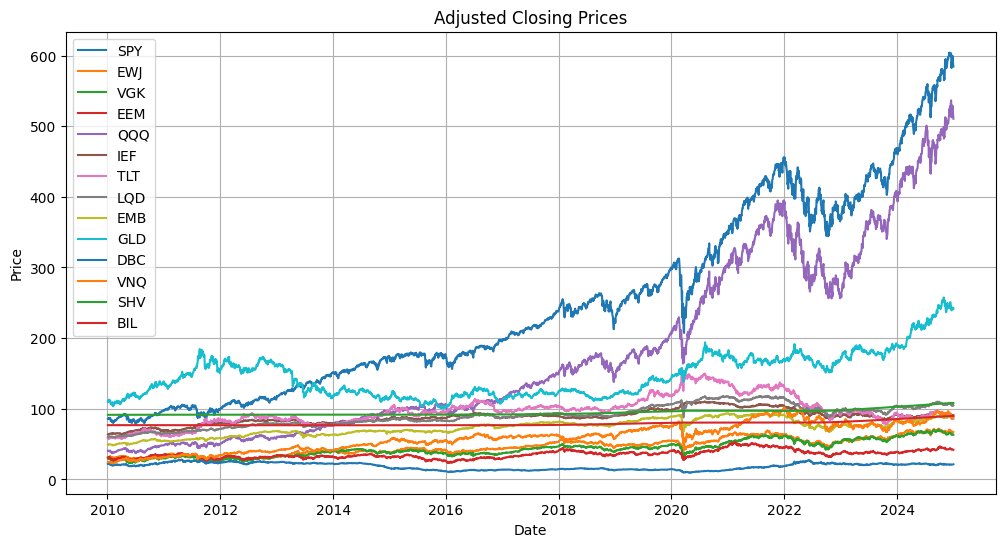

In [24]:
# Plot data
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(prices[ticker], label=ticker)

plt.title('Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
returns = prices.pct_change().dropna()
display(returns.head(5))

Ticker,BIL,DBC,EEM,EMB,EWJ,GLD,IEF,LQD,QQQ,SHV,SPY,TLT,VGK,VNQ
Date,,,,,,,,,,,,,,
2010-01-05,-0.000218,0.001189,0.007259,0.006083,0.006006,-0.000911,0.004391,0.004776,0.000000,-0.000363,0.002647,0.006458,-0.001602,-0.001123
2010-01-06,0.000000,0.017808,0.002092,0.001365,0.003980,0.016500,-0.004036,-0.002946,-0.006032,0.000090,0.000704,-0.013387,0.006014,-0.001798
2010-01-07,0.000000,-0.012442,-0.005799,-0.005161,-0.008920,-0.006188,0.000000,0.001239,0.000650,0.000000,0.004221,0.001682,-0.006376,0.010806
2010-01-08,0.000000,-0.000787,0.007933,0.001175,0.012000,0.004963,0.001238,0.002190,0.008231,0.000364,0.003327,-0.000447,0.010028,-0.007350
2010-01-11,0.000000,-0.003152,-0.002084,0.007626,0.008893,0.013289,0.000675,0.001046,-0.004082,0.000000,0.001397,-0.005487,0.007943,0.005833


In [26]:
# Function to compute Compound Annual Growth Rate (CAGR)
def compute_cagr(price, ann_multiple=252):
    n = len(price)
    cagr = (price.iloc[-1] / price.iloc[0]) ** (ann_multiple / n) - 1
    return cagr

# Function to compute Volatility
def compute_vol(price, ann_multiple=252):
    ret = price / price.shift(1) - 1  # Calculate returns
    n = len(price)  # Get the length of the time series
    mu = np.nanmean(ret)  # Calculate the mean
    sigma_daily = np.sqrt(np.nansum((ret - mu) ** 2) / (n - 1))  # Calculate daily volatility
    sigma = np.sqrt(ann_multiple) * sigma_daily  # Annualize the volatility
    return sigma

# Function to compute Sharpe Ratio
def compute_sr(price, ret_without_risk=0.00, ann_multiple=252):
    cagr = compute_cagr(price, ann_multiple)  # CAGR
    vol = compute_vol(price, ann_multiple)  # Volatility
    sr = (cagr - ret_without_risk) / vol
    return sr

Covariance matrix :
 Ticker           BIL           DBC           EEM           EMB           EWJ  \
Ticker                                                                         
BIL     2.831005e-08 -6.718091e-08 -1.449078e-08 -1.789325e-08  7.526521e-09   
DBC    -6.718091e-08  1.177204e-04  6.795877e-05  1.801916e-05  4.099065e-05   
EEM    -1.449078e-08  6.795877e-05  1.837170e-04  4.227194e-05  1.039366e-04   
EMB    -1.789325e-08  1.801916e-05  4.227194e-05  3.347407e-05  2.786176e-05   
EWJ     7.526521e-09  4.099065e-05  1.039366e-04  2.786176e-05  1.230074e-04   
GLD     4.202994e-09  3.327264e-05  2.253939e-05  1.335523e-05  1.003254e-05   
IEF     2.050709e-08 -8.210343e-06 -1.273124e-05  6.842429e-06 -8.169399e-06   
LQD     3.778620e-09  2.410153e-06  1.099813e-05  1.682685e-05  8.172967e-06   
QQQ    -2.389764e-08  4.490103e-05  1.276490e-04  3.500715e-05  9.415559e-05   
SHV     9.711099e-09 -7.738035e-08 -6.326088e-08  6.447133e-08 -6.714656e-09   
SPY    -3.008982e-0

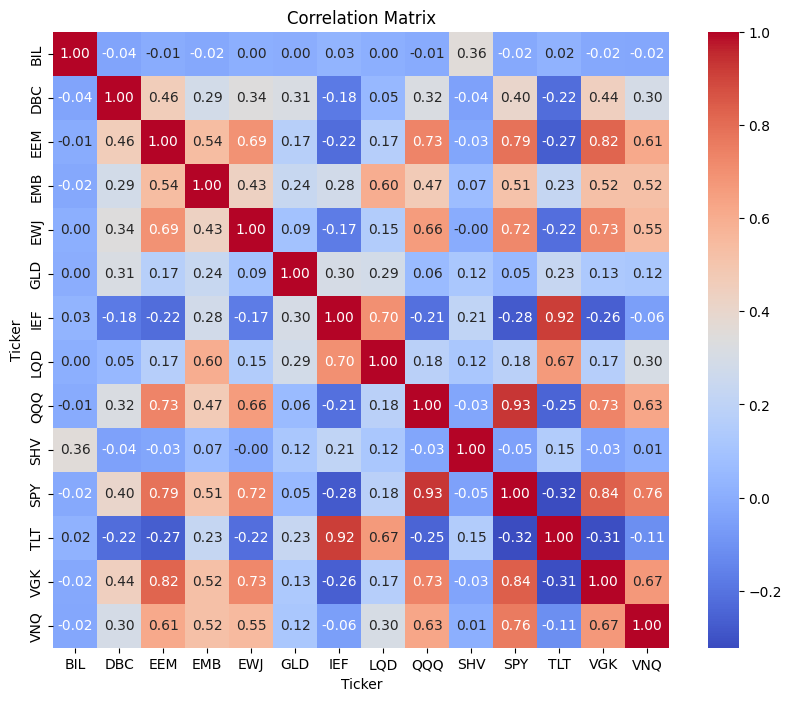

In [27]:
volatilites = prices.apply(compute_vol)

cov_mat = returns.cov()
corr_mat = returns.corr()

print('Covariance matrix :\n', cov_mat)
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

C:\Users\jqygn\AppData\Local\Temp\ipykernel_22252\759813682.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebalancing_dates = returns.resample('Q').last().index


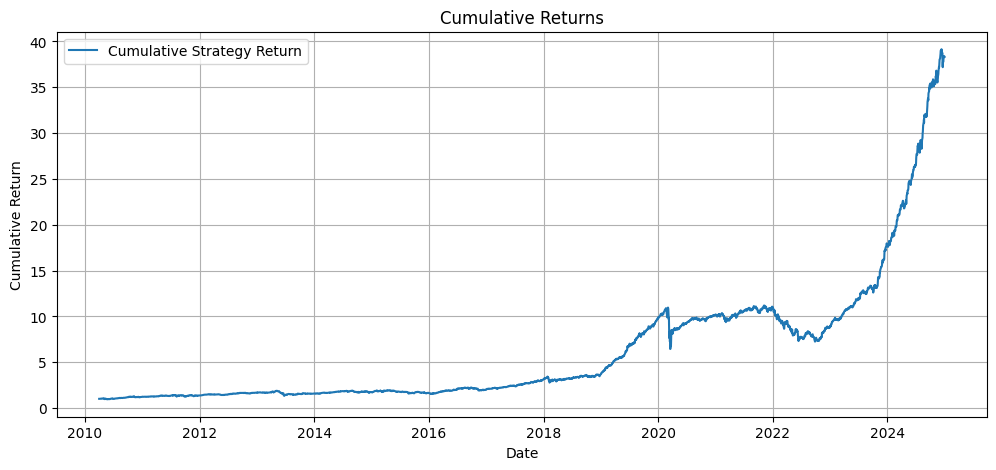

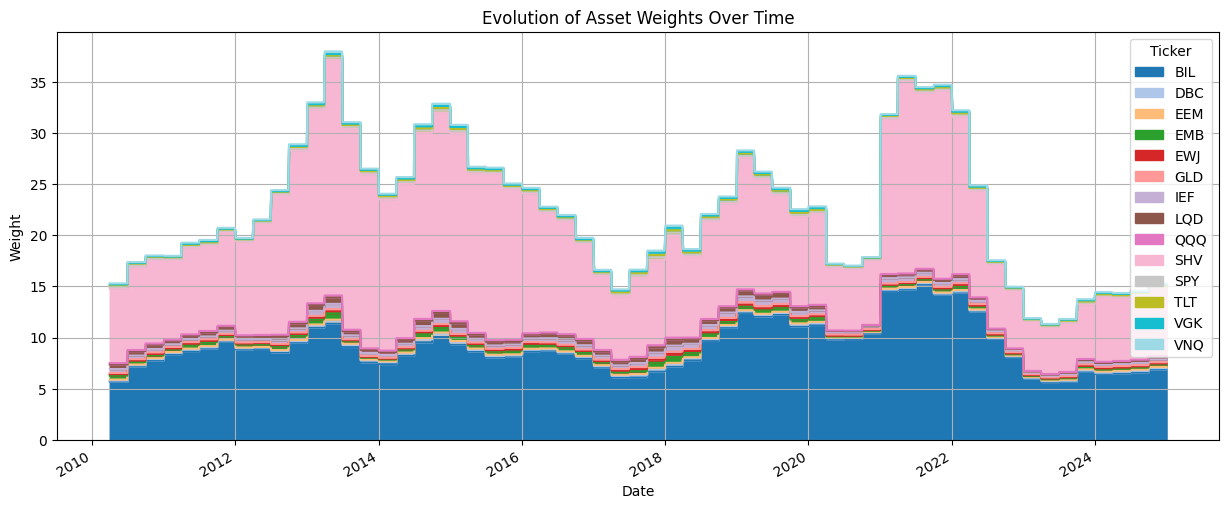

In [28]:
TARGVOL = 0.15

# Rebalancing dates (quarterly)
rebalancing_dates = returns.resample('Q').last().index

# Initialize dataframe to store strategy returns and weights
strategy_ret = pd.DataFrame(index=returns.index, columns=['Strategy_ret'])
weights_df = pd.DataFrame(index=returns.index, columns=returns.columns)

for index_t in range(len(rebalancing_dates) - 1):
    t = rebalancing_dates[index_t]

    # Data for the past year
    past_year_returns = returns.loc[t - pd.DateOffset(days=252):t]

    # Calculate annualized covariance for the past year
    ex_ante_cov = past_year_returns.cov() * 252

    # Calculate annualized volatilities
    vol = np.sqrt(np.diag(ex_ante_cov.values))

    # Equal risk weights
    weights = 1 / vol
    weights /= weights.sum()

    # Ex ante volatility of strategy
    strategy_vol = np.sqrt(weights @ ex_ante_cov @ weights)

    # Compute leverage
    leverage = TARGVOL / strategy_vol

    # Adjusted weights
    adjusted_weights = weights * leverage

    # Date range between two rebalancing dates
    index_return = slice(rebalancing_dates[index_t] + pd.Timedelta(days=1),
                         rebalancing_dates[index_t + 1])

    # Apply weights to compute returns
    strategy_ret.loc[index_return, 'Strategy_ret'] = returns.loc[index_return].dot(adjusted_weights)

    # Store weights for each date in the period
    for date in returns.loc[index_return].index:
        weights_df.loc[date] = adjusted_weights

strategy_ret.dropna(inplace=True)
weights_df.dropna(inplace=True)

# Plot cumulative returns
cumulative_returns = (1 + strategy_ret).cumprod()
plt.figure(figsize=(12, 5))
plt.plot(cumulative_returns, label='Cumulative Strategy Return')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()

# Plot weights evolution
weights_df.plot(kind='area', stacked=True, cmap='tab20', figsize=(15, 6), title='Evolution of Asset Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.show()


In [29]:
weights_df['total'] = weights_df.sum(axis=1)
weights_df

Ticker,BIL,DBC,EEM,EMB,EWJ,GLD,IEF,LQD,QQQ,SHV,SPY,TLT,VGK,VNQ,total
Date,,,,,,,,,,,,,,,
2010-04-01,5.705937,0.1066,0.090643,0.388345,0.140582,0.113707,0.383449,0.453345,0.132135,7.274865,0.149574,0.178984,0.083452,0.101456,15.303075
2010-04-05,5.705937,0.1066,0.090643,0.388345,0.140582,0.113707,0.383449,0.453345,0.132135,7.274865,0.149574,0.178984,0.083452,0.101456,15.303075
2010-04-06,5.705937,0.1066,0.090643,0.388345,0.140582,0.113707,0.383449,0.453345,0.132135,7.274865,0.149574,0.178984,0.083452,0.101456,15.303075
2010-04-07,5.705937,0.1066,0.090643,0.388345,0.140582,0.113707,0.383449,0.453345,0.132135,7.274865,0.149574,0.178984,0.083452,0.101456,15.303075
2010-04-08,5.705937,0.1066,0.090643,0.388345,0.140582,0.113707,0.383449,0.453345,0.132135,7.274865,0.149574,0.178984,0.083452,0.101456,15.303075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6.886973,0.135572,0.115238,0.244897,0.095138,0.119043,0.25808,0.259929,0.096286,6.558915,0.139456,0.126134,0.134485,0.11221,15.282357
2024-12-26,6.886973,0.135572,0.115238,0.244897,0.095138,0.119043,0.25808,0.259929,0.096286,6.558915,0.139456,0.126134,0.134485,0.11221,15.282357
2024-12-27,6.886973,0.135572,0.115238,0.244897,0.095138,0.119043,0.25808,0.259929,0.096286,6.558915,0.139456,0.126134,0.134485,0.11221,15.282357


In [30]:
# Compute CAGR
final_cum_return = cumulative_returns.values[-1].item()

CAGR = final_cum_return ** (252 / strategy_ret.shape[0]) - 1
print(f'CAGR: {CAGR:.2%}')

# Compute Sharpe ratio

# Parameters
risk_free_rate = 0.0
ann_multiple = 252

# Annualized mean return (arithmetic)
mean_daily_return = strategy_ret.values.mean()
annualized_return = mean_daily_return * ann_multiple

# Annualized volatility
daily_vol = strategy_ret.values.std()
annualized_vol = daily_vol * np.sqrt(ann_multiple)

# Sharpe Ratio
SR = (annualized_return - risk_free_rate) / annualized_vol

print(f'Sharpe Ratio: {SR:.2f}')


CAGR: 28.07%
Sharpe Ratio: 1.44
